# Chapter 7.2: Pennies II (Drag)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [2]:
# import libraries
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

In the previous chapter we simulated a penny falling in a vacuum, that
is, without air resistance. But the computational framework we used is
very general; it is easy to add additional forces, including drag.

In this chapter, I present a model of drag force and add it to the
simulation.

## Drag Force

As an object moves through a fluid, like air, the object applies force
to the air and, in accordance with the third law of motion, the air applies an equal and opposite force to the object (see
<http://modsimpy.com/newton>).

The direction of this *drag force* is opposite the direction of
travel, and its magnitude is given by the drag equation (see
<http://modsimpy.com/drageq>): 

$$F_d = \frac{1}{2}~\rho~v^2~C_d~A$$

where

-   $F_d$ is force due to drag, in newtons (N).

-   $\rho$ is the density of the fluid in kg/m$^3$.

-   $v$ is the magnitude of velocity in m/s.

-   $A$ is the *reference area* of the object, in m$^2$. In this
    context, the reference area is the projected frontal area, that is, the visible area of the object as seen from a point on its line of
    travel (and far away).

-   $C_d$ is the *drag coefficient*, a dimensionless quantity that
    depends on the shape of the object (including length but not frontal area), its surface properties, and how it interacts with the fluid.

For objects moving at moderate speeds through air, typical drag
coefficients are between 0.1 and 1.0, with blunt objects at the high end of the range and streamlined objects at the low end (see
<http://modsimpy.com/dragco>).

For simple geometric objects we can sometimes guess the drag coefficient with reasonable accuracy; for more complex objects we usually have to take measurements and estimate $C_d$ from data.

Of course, the drag equation is itself a model, based on the assumption that $C_d$ does not depend on the other terms in the equation: density, velocity, and area. For objects moving in air at moderate speeds (below 45 mph or 20 m/s), this model might be good enough, but we will revisit this assumption in the next chapter.

For the falling penny, we can use measurements to estimate $C_d$. In
particular, we can measure *terminal velocity*, $v_{term}$, which is
the speed where drag force equals force due to gravity:

$$\frac{1}{2}~\rho~v_{term}^2~C_d~A = m g$$ 

where $m$ is the mass of the object and $g$ is acceleration due to gravity. Solving this equation for
$C_d$ yields: 

$$C_d = \frac{2~m g}{\rho~v_{term}^2~A}$$ 

According to *Mythbusters*, the terminal velocity of a penny is between 35 and 65 mph (see <http://modsimpy.com/mythbust>). Using the low end of their range, 40 mph or about 18 m/s, the estimated value of $C_d$ is 0.44, which is close to the drag coefficient of a smooth sphere.

Now we are ready to add air resistance to the model. But first I want to introduce one more computational tool, the `Params` object.

## Setting up the system

Here's the `params` object for the falling penny (in base metric units).  Since there are a lot of parameters, we'll store this in a `dictionary` rather than just as a `tuple` (which is what we've used in previous chapters--a `tuple` is a simple sequence of variables):


In [53]:
params = dict(
    mass = 0.0025,      
    diameter = 0.019,   
    rho = 1.2,          
    g = 9.8,            
    v_init = 0,        
    v_term = 18,        
    height = 381,       
    t_end = 30,         
    )

The mass and diameter are from <http://modsimpy.com/penny>. The density
of air depends on temperature, barometric pressure (which depends on
altitude), humidity, and composition (see <http://modsimpy.com/density>). 
I chose a value that might be typical in New York City at 20 °C.

Here's a version of `make_system` that takes the `params` object and computes the inital state, `init`, the area, and the coefficient of drag.
Then it returns a `system` object with the quantities we'll need for the simulation. 

In [54]:
from numpy import pi

def make_system(params):
    # unpack the parameters
    mass, diameter, rho, g, v_init, v_term, height, t_end = params.values()
    
    init = pd.Series(dict(y=height, v=v_init))

    area = pi * (diameter/2)**2

    C_d = (2 * mass * g / 
           (rho * area * v_term**2))

    return dict(init=init,
                  area=area,
                  C_d=C_d,
                  mass=mass,
                  rho=rho,
                  g=g,
                  v_term = v_term,
                  t_end=t_end)

And here's how we call it.

In [55]:
system = make_system(params)

Based on the mass and diameter of the penny, the density of air, and acceleration due to gravity, and the observed terminal velocity, we estimate that the coefficient of drag is about 0.44.

In [61]:
system['C_d']

0.4445009981135434

It might not be obvious why it is useful to create a `params` object just to create a `system` object.
In fact, if we only run one simulation, it might not be useful.  But it helps when we want to change or sweep the parameters.

For example, suppose we learn that the terminal velocity of a penny is actually closer to 20 m/s.
We can make a `params` object with the new value, and a corresponding `system` object, like this:

In [66]:
# Create a new dictionary object
params1 = params.copy()

# Update one of the terms in the new object
# Notice that update takes a dictionary as its argument
params1.update(dict(v_term=20))
params1

{'mass': 0.0025,
 'diameter': 0.019,
 'rho': 1.2,
 'g': 9.8,
 'v_init': 0,
 'v_term': 20,
 'height': 381,
 't_end': 30}

The result is a new `params` object that is identical to the original except for the given value of `v_term`. 
If we pass `params1` to `make_system`, we see that it computes a different value of `C_d`.

In [67]:
system1 = make_system(params1)
system1['C_d']

0.3600458084719701

If the terminal velocity of the penny is 20 m/s, rather than 18 m/s, that implies that the coefficient of drag is 0.36, rather than 0.44.
And that makes sense, since lower drag implies faster terminal velocity.

Using `params` objects to make `system` objects helps make sure that relationships like this are consistent.  And since we are always making new objects, rather than modifying existing objects, we are less likely to make a mistake.

## Simulating the Penny Drop

Now let's get to the simulation.  Here's a version of the slope function that includes drag:

In [68]:
def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    mass, g = system['mass'], system['g']
    
    f_drag = rho * v**2 * C_d * area / 2
    if v < 0:
        a_drag = f_drag / mass 
    else:
        a_drag = -f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag 
    
    return dydt, dvdt

As usual, the parameters of the slope function are a time stamp, a `state` object, and a `system` object. 

We don't use `t` in this example, but we can't leave it out because when `run_solve_ivp` calls the slope function, it always provides the same arguments, whether they are needed or not.

`f_drag` is force due to drag, based on the drag equation. `a_drag` is
acceleration due to drag, based on the second law.

To compute total acceleration, we add accelerations due to gravity and
drag. 

- `g` is negative because it is in the direction of decreasing `y`
- Drag always opposes motion.  So the sign of `a_drag` is set to be opposite the sign of velocity.  

In the next chapter we will use `Vector` objects to keep track of
the direction of forces and add them up in a less error-prone way.

As usual, let's test the slope function with the initial conditions.

In [71]:
slope_func(0, system['init'], system)

(0, -9.8)

Because the initial velocity is 0, so is the drag force, so the initial acceleration is still `g`. 

To stop the simulation when the penny hits the sidewalk, we'll use the
event function from the previous chapter.

In [78]:
def event_func(t, state, system):
    y, v = state
    return y

Now we can run the simulation like this:

In [79]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

Here are the last few time steps:

In [80]:
results.tail()

,y,v
21.541886,1.614743e+01,-18.001510
21.766281,1.211265e+01,-18.006240
21.990676,8.076745e+00,-18.009752
22.215070,4.039275e+00,-18.011553
22.439465,7.105427e-15,-18.011383


The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which is a reminder that the simulation results are only approximate.

We can get the flight time from `results`.

In [81]:
t_sidewalk = results.index[-1]
t_sidewalk

22.43946505804431

With air resistance, it takes about 22 seconds for the penny to reach the sidewalk.

Here's a plot of position as a function of time.

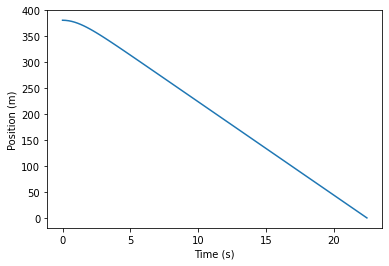

In [82]:
def plot_position(results):
    results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)')
    
plot_position(results)

And velocity as a function of time:

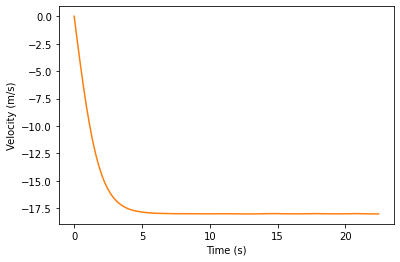

In [83]:
def plot_velocity(results):

    results.v.plot(color='C1', label='v',
                   xlabel='Time (s)', 
                   ylabel='Velocity (m/s)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

## Summary

This chapter presents a model of drag force, which we use to estimate the coefficient of drag for a penny, and then simulate, one more time, dropping a penny from the Empire State Building.

In the next chapter we'll move from one dimension to two, simulating the flight of a baseball.

### Exercise 1

 Run the simulation with a downward initial velocity that exceeds the penny's terminal velocity.

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

Hint: Use make a new `params` object with a different initial velocity.

In [84]:
# Set the params for the simulation  and make the system
params_d = params.copy()
params_d.update(dict(v_init=-30))
system_d = make_system(params_d)

In [85]:
# Use run_solve_ivp
results_d, details = run_solve_ivp(system_d, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

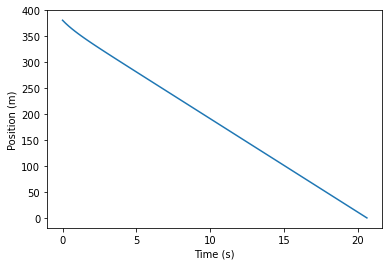

In [86]:
# Plot the position vs. time
plot_position(results_d)

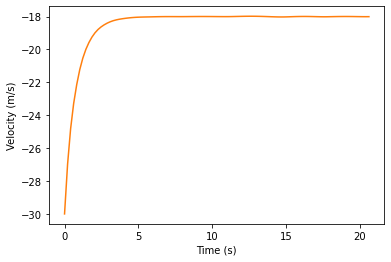

In [87]:
# Plot the velocity vs. time
plot_velocity(results_d)

### Exercise 2

 Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  Use this measurement to estimate terminal velocity and coefficient of drag.

You can get the relevant dimensions of a quarter from <https://en.wikipedia.org/wiki/Quarter_(United_States_coin)>.

1. Create a `params` object with new values of `mass` and `diameter`. We don't know `v_term`, so we'll start with the initial guess 18 m/s.

2. Use `make_system` to create a `system` object.  

3. Call `run_solve_ivp` to simulate the system.  How does the flight time of the simulation compare to the measurement?

4. Try a few different values of `v_term` and see if you can get the simulated flight time close to 19.1 seconds.

5. Write an error function and use `root_scalar` to improve your estimate (See chapter 4.1 for help).

6. Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the "observed" flight time, so don't take the results of this exercise too seriously.

In [88]:
# Create a new params object and make a system
params_q = params.copy()
params_q.update(dict(mass = 0.00567,
                     diameter = 0.02426,
                     v_term = 21.7))
system_q = make_system(params_q)

In [89]:
# Test with assumed terminal velocity; iterate manually to find approximate
# value for v_term
results_q, details = run_solve_ivp(system_q, slope_func,
                                 events=event_func)
results_q.index[-1]

19.091421165836625

In [92]:
# Write an error_func 

def error_func_coin(v_term, system):
    system['v_term'] = v_term
    
    rho, area = system['rho'], system['area']
    mass, g = system['mass'], system['g']
    
    system['C_d'] = (2 * mass * g / 
       (rho * area * v_term**2))
    
    results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
    return results.index[-1] - 19.1


In [93]:
# Run root scalar to find the best v_term

res = root_scalar(error_func_coin, system_q, bracket=[10, 30])
res

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 21.6884006959541

In [96]:
# Check your answer nad Calculate the best C_d

params_q_final = params_q.copy()
params_q_final.update(dict(v_term = 21.688400))
system_q_final = make_system(params_q_final)
results_q_final, details = run_solve_ivp(system_q_final, slope_func,
                                 events=event_func)
print('Time:', results_q_final.index[-1])
print('Coefficient of Drag:', system_q_final['C_d'])


Time: 19.100000815572
Coefficient of Drag: 0.42592328273489666
